In [149]:
import pandas as pd
from minicons import cwe
from torch.utils.data import DataLoader
import torch
from collections import defaultdict
from tqdm import tqdm
import re
from model import FFNModule, FeatureNormPredictor, FFNParams, TrainingParams

In [150]:
# first want to clean the data
# uploading both csvs

do_df = pd.read_csv("dative_data/direct_object.csv")
po_df = pd.read_csv("dative_data/prepositional.csv")

In [151]:
# convert csvs into lists of sentence word pairs
do_list_natural = do_df[['sentence','recipient']].values.tolist()
do_list_alternate = do_df[['alternant','recipient']].values.tolist()
po_list_natural = po_df[['sentence','recipient']].values.tolist()
po_list_alternate = po_df[['alternant','recipient']].values.tolist()

In [152]:
do_list_natural[1]

['Rodolfo gives Mimi the pink bonnet he bought her, which he has kept as a souvenir of their love.',
 'mimi']

In [153]:
do_list_natural[1][1] in do_list_natural[1][0]

False

In [154]:
def _find_word_form(word, sentence):
  '''find how word occurs in sentence'''
  matches = re.finditer(word, sentence.lower())
  for match in matches:
    span = match.span()
    if (span[0] == 0 or sentence[span[0]-1] == ' ') and (span[1] == len(sentence) or sentence[span[1]] == ' ' or sentence[span[1]] == '.' or sentence[span[1]] == '!' or sentence[span[1]] == '?' or sentence[span[1]] == ',' or sentence[span[1]] == ';'):
      return tuple(span)
  return None
  print(f"no match found for {word} in {sentence}")
  raise Exception("no match found")

In [155]:
# have to convert the 'words' to spans
datasets = [do_list_natural, do_list_alternate, po_list_natural, po_list_alternate]
datasets_spans = []
for set in datasets:
    new_data = []
    for pair in set:
        sentence = pair[0]
        word = pair[1]

        # get the word's span
        wordspan = _find_word_form(word, sentence)
        if wordspan: 
            new_data.append((sentence, torch.tensor(wordspan)))
        else:
            print(f"no span found for {word} in {sentence}")
    datasets_spans.append(new_data)

no span found for the members of the sarcastic gamer community (the forums) in The Sarcastic Gamer Community Podcast is not a podcast, but an initiative designed to give the members of the Sarcastic Gamer Community (the forums) a chance to make their own podcast and have it featured on the site.
no span found for the members of the sarcastic gamer community (the forums) in The Sarcastic Gamer Community Podcast is not a podcast, but an initiative designed to give a chance to make their own podcast and have it featured on the site to the members of the Sarcastic Gamer Community (the forums).
no span found for many of the senators and their men , men who once considered him an enemy in Nor did Ptolemy take into account that Caesar was granting amnesty to many of the senators and their men, men who once considered him an enemy.
no span found for this 40 year travesty of justice in In May 2007 West joined a demonstration against "injustices faced by the Palestinian people resulting from the

In [156]:
"the members of the sarcastic gamer community (the forums)" in "The Sarcastic Gamer Community Podcast is not a podcast, but an initiative designed to give the members of the Sarcastic Gamer Community (the forums) a chance to make their own podcast and have it featured on the site.".lower()

True

In [193]:
for set in datasets_spans:
    print(len(set))

999
999
939
955


In [158]:
re.findall("the members of the sarcastic gamer community (the forums)", "The Sarcastic Gamer Community Podcast is not a podcast, but an initiative designed to give the members of the Sarcastic Gamer Community (the forums) a chance to make their own podcast and have it featured on the site.".lower())

[]

In [159]:
# extract all the embeddings and do predictions
lms = ['roberta-base', 'bert-base-uncased', 'albert-xxlarge-v2']
# hierarchy is model: dataset: layer: average feature prediction vector
preds_per_model = {'bert-base-uncased': [], 'albert-xxlarge-v2': [], 'roberta-base': []}
num_features = 65 # binder
for model in lms:
    # load lm for embedding extraction
    lm = cwe.CWE(model)
    # load my models
    nick_name = str.split(model, "-")[0]
    classifiers = []
    for layer in range(13):
        path = f"saved_models/{nick_name}_models_all/{nick_name}_to_binder_layer{layer}.ckpt"
        my_mo = FeatureNormPredictor.load_from_checkpoint(
            checkpoint_path=path,
            map_location={"cuda:1":"cpu", "cuda:2":"cpu"}
        )
        my_mo.eval()
        classifiers.append(my_mo)
    
    for set in datasets_spans:
        # initialize a dictionary for our predictions to live in
        layerwise_predictions = defaultdict(lambda : torch.zeros(num_features).unsqueeze(0))

        dl = DataLoader(set, batch_size=16)
        # tqdm is progress bar
        for batch in tqdm(dl):
            sentences, words = batch
            batched_query = list(zip(sentences, words))
            # we have a 3d tensor: layer: sentence: embedding
            layer_embs = lm.extract_representation(batched_query, layer='all')
            for layer, embs in enumerate(layer_embs):
                for i in range(0, embs.size(0)):
                    emb = embs[i]
                    # this is a nan check
                    if layer == 0:
                        query = batched_query[i]
                        if emb.isnan().any():
                            print("nan detected in extracted embeddings, offending query:")
                            print(f"query: {query}")
                            raise Exception("nan found in embedding")
                    # perform prediction on this embedding
                    my_mo = classifiers[layer]
                    pred = torch.nn.functional.relu(my_mo(emb))
                    pred = pred.squeeze(0)
                    # add this to the calculation
                    layerwise_predictions[layer] += (pred/len(set))

        layerwise_predictions = dict(layerwise_predictions)
        preds_per_model[model].append(layerwise_predictions)


100%|██████████| 60/60 [02:37<00:00,  2.63s/it]


In [169]:
# checking that structure is as expected
# embs_per_model[model][dataset][layer] should give a 1 d vector
preds_per_model['bert-base-uncased'][3][8].detach().tolist()[0]

[3.104410171508789,
 0.6607001423835754,
 0.4791991710662842,
 0.9697983860969543,
 1.0440534353256226,
 1.290106177330017,
 0.9156562685966492,
 1.3417290449142456,
 1.911380648612976,
 0.6414332389831543,
 0.6304558515548706,
 2.067289113998413,
 1.1869393587112427,
 1.6165096759796143,
 1.8456848859786987,
 1.1330486536026,
 0.5116366147994995,
 1.087837815284729,
 1.5656912326812744,
 0.5224120616912842,
 1.1814593076705933,
 0.6825432181358337,
 0.3178146183490753,
 0.42215049266815186,
 1.0666487216949463,
 0.4294666349887848,
 1.5297707319259644,
 0.35299673676490784,
 0.7187259793281555,
 0.9621589183807373,
 1.3236238956451416,
 0.6632809042930603,
 1.4246851205825806,
 0.8989567756652832,
 0.5224722027778625,
 1.7169456481933594,
 1.2974801063537598,
 0.5264542698860168,
 0.40537601709365845,
 0.7510032653808594,
 0.7246420979499817,
 0.900593101978302,
 0.9529380202293396,
 0.5424475073814392,
 1.0276210308074951,
 1.2942159175872803,
 1.5347371101379395,
 1.6463474035263062

In [172]:
# data vis time ヾ(⌐■_■)ノ♪
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

In [167]:
label_path = "saved_models/bert_models_all/bert_to_binder_layer8.txt"
with open (label_path, "r") as file:
    labels = [line.rstrip() for line in file.readlines()]

In [194]:
# make a df for bert layer 8

data = pd.DataFrame({
    "feature": labels,
    "DO_natural": preds_per_model['bert-base-uncased'][0][8].detach().tolist()[0],
    "DO_alter": preds_per_model['bert-base-uncased'][1][8].detach().tolist()[0],
    "PO_natural": preds_per_model['bert-base-uncased'][2][8].detach().tolist()[0],
    "PO_alter": preds_per_model['bert-base-uncased'][3][8].detach().tolist()[0],
})
data.loc[:,'DO_change'] = data["DO_alter"] - data["DO_natural"]
data.loc[:,'PO_change'] = data["PO_alter"] - data["PO_natural"]
data.loc[:,'natural_diff'] = (data["DO_natural"] - data["PO_natural"]).abs()
data.loc[:,'avg_diff_mag'] = (data["DO_change"].abs() + data["PO_change"].abs())/2

data.loc[:,'center_val'] = (data["DO_natural"] + data["PO_natural"])/2
data.loc[:,'DO_nat_center'] = data["DO_natural"] - data["center_val"]
data.loc[:,'PO_nat_center'] = data["PO_natural"] - data["center_val"]
data.head()

,feature,DO_natural,DO_alter,PO_natural,PO_alter,DO_change,PO_change,natural_diff,avg_diff_mag,center_val,DO_nat_center,PO_nat_center
0,Vision,2.895803,2.878946,3.271316,3.104410,-0.016857,-0.166906,0.375513,0.091882,3.083560,-0.187757,0.187757
1,Bright,0.543461,0.615958,0.766476,0.660700,0.072497,-0.105776,0.223015,0.089137,0.654968,-0.111508,0.111508
2,Dark,0.408766,0.447420,0.520727,0.479199,0.038654,-0.041528,0.111961,0.040091,0.464747,-0.055981,0.055981
3,Color,0.852957,0.897632,1.028237,0.969798,0.044674,-0.058439,0.175280,0.051556,0.940597,-0.087640,0.087640
4,Pattern,1.046507,1.027146,1.093929,1.044053,-0.019362,-0.049875,0.047421,0.034618,1.070218,-0.023711,0.023711


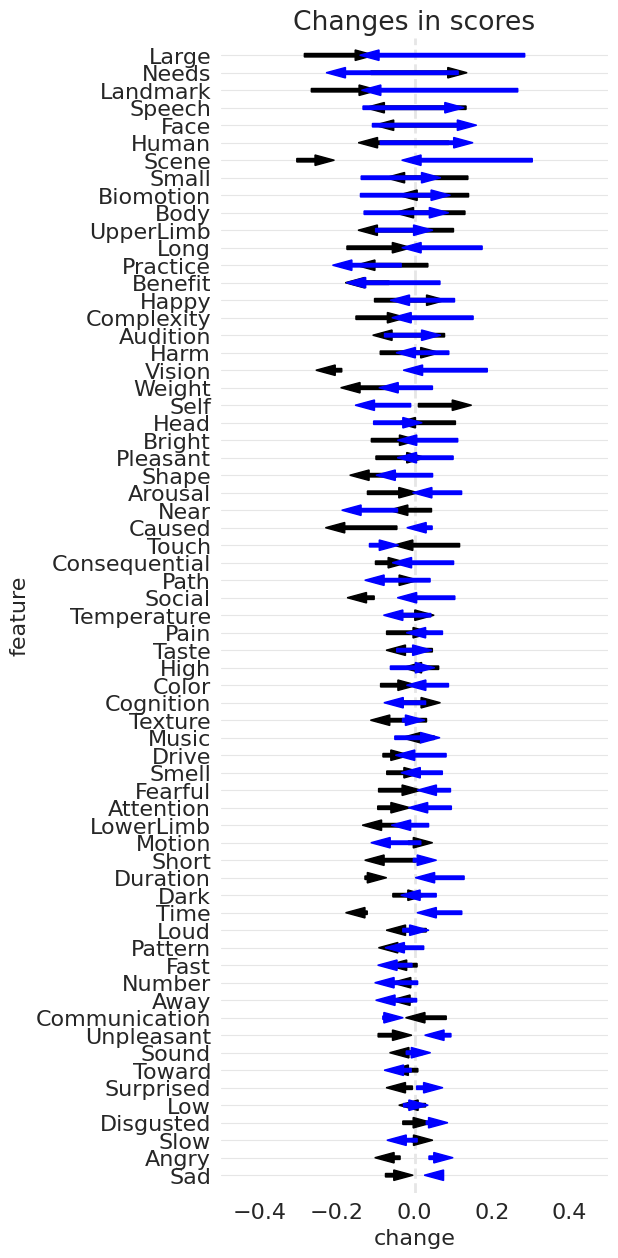

In [195]:
# just plotting the DO change
#sort features by amount of change, from largest to smallest
data = data.sort_values(by='avg_diff_mag', ascending=True) \
           .reset_index(drop=True)

#initialize a plot
fig, ax = plt.subplots(figsize=(5,15))
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-1,num_features)
ax.set_yticks(range(num_features))
ax.set_yticklabels(data['feature'])

#define arrows
arrow_starts_DO = data['DO_nat_center']
arrow_starts_PO = data['PO_nat_center']
arrow_lengths_DO = data['DO_change'].values
arrow_lengths_PO = data['PO_change'].values

#add arrows to plot
for i, subject in enumerate(data['feature']):
    # DO arrows
    ax.arrow(arrow_starts_DO[i],        #x start point
             i,                      #y start point
             arrow_lengths_DO[i],       #change in x 
             0,                      #change in y
             head_width=0.6,         #arrow head width
             head_length=0.05,        #arrow head length
             width=0.2,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color
    ax.arrow(arrow_starts_PO[i],        #x start point
             i,                      #y start point
             arrow_lengths_PO[i],       #change in x 
             0,                      #change in y
             head_width=0.6,         #arrow head width
             head_length=0.05,        #arrow head length
             width=0.2,              #arrow stem width
             fc='blue',             #arrow fill color
             ec='blue')             #arrow edge color

#format plot
ax.set_title('Changes in scores')                     #add title
ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0) #add line at x=0
ax.grid(axis='y', color='0.9')                        #add a light grid
ax.set_xlim(-0.5,0.5)                                     #set x axis limits
ax.set_xlabel('change')                               #label the x axis
ax.set_ylabel('feature')                          #label the y axis
sns.despine(left=True, bottom=True)                   #remove axes